In [1]:
#필요한 라이브러리 호출 
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

import time
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

### ImageTransform 클래스 정의 

In [2]:
#이미지 데이터 셋 전처리 
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(resize,scale =(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
        
    def __call__(self,img,phase): #클래스를 호출할 수 있도록 하는 메서드, 클래스에 __call__ 메서드가 있으면 클래스 호출 시 call의 리턴값 리턴
        return self.data_transform[phase](img)
    

### 데이터 셋 불러오기 

In [6]:
#이미지 데이터셋을 불러온 후 훈련 검증 테스트로 분리
cat_dir = r"C:/Users/2022-PC(T)-13\Desktop/SKT_FLY-AI/Torch_lecture/data/dogs-vs-cats/Cat"
dog_dir = r"C:/Users/2022-PC(T)-13\Desktop/SKT_FLY-AI/Torch_lecture/data/dogs-vs-cats/Dog"

cat_images_filepaths = sorted([os.path.join(cat_dir,f) for f in os.listdir(cat_dir)]) #cat_dir안에 이미지들을 모두 경로로 
dog_images_filepaths = sorted([os.path.join(dog_dir,f) for f in os.listdir(dog_dir)]) 

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(23)
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:400]

val_images_filepaths = correct_images_filepaths[400:-10]

test_images_filepaths = correct_images_filepaths[-10:]

print("num of train images : {}, num of validation image : {}, num of test iamges : {}".format(len(train_images_filepaths),
                                                                                               len(val_images_filepaths),
                                                                                                 len(test_images_filepaths)))

num of train images : 400, num of validation image : 92, num of test iamges : 10


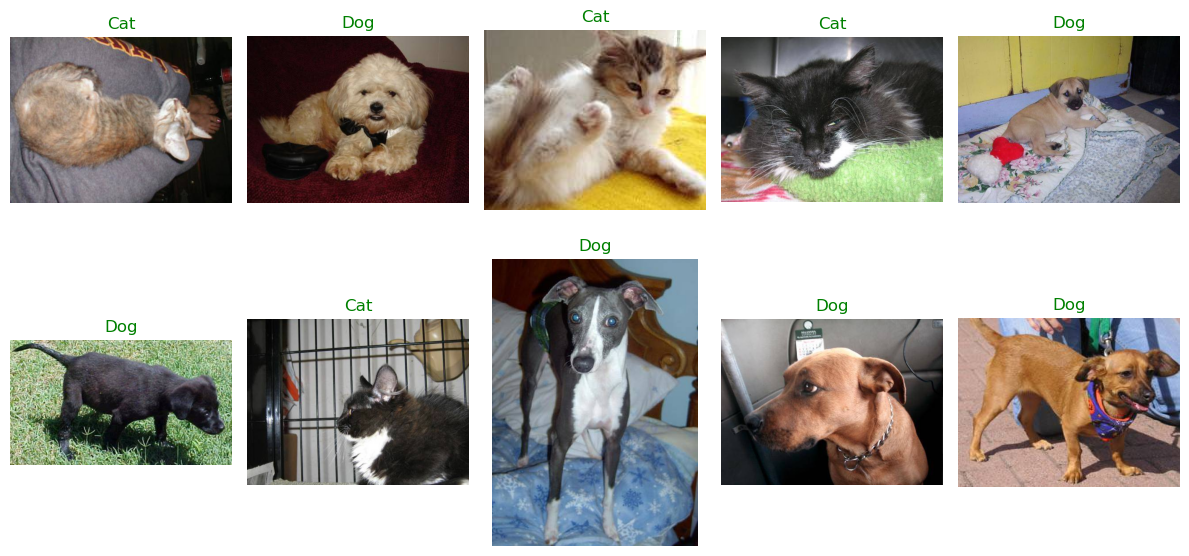

In [7]:
#테스트 데이터 셋 이미지 확인 함수 작성 
def display_image_grid(images_filepaths, predicted_labels=(), cols =5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12,6))
    
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #이미지 전체 경로를 정규화하고 분할하는 코드 
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label,color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)

### 커스텀 데이터 셋 클래스 정의 

In [8]:
#init len getitem 
# 이미지 데이터 셋 클래스 정의 
class DogvsCatDataset(Dataset):
    def __init__(self,file_list,transform=None,phase = 'train'):
        self.file_list = file_list
        self.transforms = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transforms(img,self.phase)
        label = img_path.split('\\')[-1].split('.')[0] #file 명에서 dog 인지 cat 인지 추출하는 것 
        if label == 'dog':
            label = 1 
        elif label == 'cat':
            label = 0
        return img_transformed, label 

In [104]:
#변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406) # image net dataset의 평균
std = (.229, .224, .225)
batch_size = 16

### Dataset 정의 

In [105]:
#이미지 데이터 셋 정의 
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size,
                                                                                mean,std),phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths,transform = ImageTransform(size,
                                                                             mean,std),phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


### 데이터 셋 정의했으니까 데이터 로더 정의 

In [106]:
#데이터로더 정의
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size,shuffle = False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator) 
print(inputs.size())
print(label)

torch.Size([16, 3, 224, 224])
tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0])


### 데이터 로더까지 끝났으니까 모델링 

In [12]:
#모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size = 5,stride = 1,padding = 0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size=5,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.fc1 = nn.Linear(32*53*53,512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512,2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [13]:
#모델 객체 생성
model = LeNet()
model.to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [15]:
from torchsummary import summary
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
          Softmax-10                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Es

In [16]:
#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr = 0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

#모델의 파라미터와 손실 함수를 디바이스에 할당
model = model.to(device)
criterion = criterion.to(device)

### trainer 정의 

In [91]:
def train_model(model,dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}".format(epoch+1,num_epoch))
        print("-"*20)
        
        for phase in ['train','val']:
            if phase =='train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() #역전파를 실행하기 전에 기울기 0으로 초기화 
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _,preds = torch.max(outputs,1)
                    # _, preds = torch.max(outputs, 1)
                    _ , preds = torch.max(outputs[0],1)

                    loss = criterion(outputs,labels) #손실함수로 오차 계산 
                    
                    if phase =='train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item()*inputs.size(0)#reduction ='mean'이기 때문에 오차를 구하고 그 값의 평균을 반환하기 때문에 배치 크기만큼 곱해줌
                    epoch_corrects += torch.sum(preds == labels.data)#정답과 예측이 같은 만큼 acc에 더해줌
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} LOSS: {:.4f} ACC: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc: #검증 데이터셋에 대해 가장 최적의 정확도를 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best val ACC {:.4f}".format(best_acc))

    return model

### 모델 학습 

In [89]:
#model 학습 
num_epoch = 15
model = train_model(model,dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/15
--------------------


C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\2089151762.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

### LeNet 필터사이즈 바꾸기 

In [58]:
class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # 224 - 3 + 2 +1 224
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #224-2 /2 + 1   = 112 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=0) #112 - 7  + 1 106
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  #106 -2 /2 + 1 = 53 
        
        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.output(out)
        return out


In [59]:
#모델 객체 생성
model2 = LeNet2()
model2.to(device)
print(model2)

LeNet2(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [60]:
#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model2.parameters(), lr = 0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

#모델의 파라미터와 손실 함수를 디바이스에 할당
model2 = model2.to(device)
criterion = criterion.to(device)

In [61]:
#model 학습 
num_epoch = 15
model2 = train_model(model2,dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/15
--------------------


C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\2489210399.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.7022 ACC: 0.4700


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6924 ACC: 0.5000
Epoch 2/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6886 ACC: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6882 ACC: 0.5543
Epoch 3/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6792 ACC: 0.5925


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6821 ACC: 0.5217
Epoch 4/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6618 ACC: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6924 ACC: 0.5326
Epoch 5/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6632 ACC: 0.6175


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6712 ACC: 0.6739
Epoch 6/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6946 ACC: 0.5525


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.7046 ACC: 0.5870
Epoch 7/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6479 ACC: 0.6525


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.7016 ACC: 0.5326
Epoch 8/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6462 ACC: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6995 ACC: 0.5543
Epoch 9/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6447 ACC: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6830 ACC: 0.5761
Epoch 10/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6191 ACC: 0.6675


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.7039 ACC: 0.5652
Epoch 11/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6449 ACC: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6740 ACC: 0.6413
Epoch 12/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6302 ACC: 0.6500


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6836 ACC: 0.5978
Epoch 13/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.5960 ACC: 0.7000


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6626 ACC: 0.5978
Epoch 14/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6126 ACC: 0.6675


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6759 ACC: 0.6087
Epoch 15/15
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.5922 ACC: 0.6950


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6602 ACC: 0.6196
Training complete in 6m 11s
Best val ACC 0.6739


### AlexNet

In [62]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True ),
            nn.MaxPool2d(kernel_size=3,stride=2),

            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True ),
            nn.MaxPool2d(kernel_size=3,stride=2),

            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True ),

            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True ),
            
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True ),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))  #출력이 256x6x6으로...풀링 이후 출력 크기를 정의해주면 출력 크기 조정이 쉬워짐 
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,2),
        )
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x

In [63]:
#모델 객체 생성
model_A = AlexNet()
model_A.to(device)
print(model_A)

#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model_A.parameters(), lr = 0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

#모델의 파라미터와 손실 함수를 디바이스에 할당
model_A = model_A.to(device)
criterion = criterion.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [90]:
#model 학습 
num_epoch = 15
model_A = train_model(model_A,dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/15
--------------------


C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\2089151762.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### VGG

In [107]:
class VGG(nn.Module):
    def __init__(self,features,output_dim):
        super().__init__()
        self.features = features # VGG모델에 대한 매개 변수에서 받아온 features값을 넣어줌 
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096,output_dim)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [108]:
vgg11_config = [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M']

vgg13_config = [64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M']

vgg16_config = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']

vgg19_config = [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']

In [109]:
def get_vgg_layers(config,batch_norm):
    layers = []
    in_channels = 3
    
    for c in config:
        assert c =='M' or isinstance(c,int) # True 가 아니면 error 발생 c == M 이 아니면 오류 발생 
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels,c,kernel_size=3,padding=1)
            if batch_norm:
                layers +=[conv2d,nn.BatchNorm2d(c),nn.ReLU(inplace=True)]
            else:
                layers += [conv2d,nn.ReLU(inplace=True)]
            in_channels = c 
    return nn.Sequential(*layers)

In [110]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
print(vgg11_layers)
OUTPUT_DIM = 2
model = VGG(vgg11_layers,OUTPUT_DIM)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [111]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### 사전 학습 모델 

In [119]:
import torch.nn as nn
import torchvision.models as models

# Load pre-trained VGG11 model
pretrained_model = models.vgg11_bn(pretrained=True)

# Modify the last fully connected layer's output size
in_features = pretrained_model.classifier[6].in_features
out_features = 2  # Set the desired output size
pretrained_model.classifier[6] = nn.Linear(in_features, out_features)

print(pretrained_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [102]:
torch.cuda.empty_cache()

In [122]:
def calculate_accuracy(y_pred,y):
    top_pred = y_pred.argmax(1,keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum() #eq : 서로 같은지 비교하는 표현식 , view_as : 텐서 크기를 반영 
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred,dummi = model(x)
        loss = criterion(y_pred,y)
        acc = calculate_accuracy(y_pred,y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0 
    epoch_acc = 0 
    
    model.eval()
    with torch.no_grad():
        for(x,y) in iterator:
            x =x.to(device)
            y = y.to(device)
            y_pred,dummi = model(x)
            loss = criterion(y_pred,y)
            acc = calculate_accuracy(y_pred,y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    return elapsed_mins, elapsed_secs

In [120]:
optimizer = optim.Adam(pretrained_model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

pretrained_model = pretrained_model.to(device)
criterion = criterion.to(device)




In [123]:
import time
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model,train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(),"./VGG-model.pt")
        
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time,end_time)
    
    print(f'Epoch : {epoch+1:02} | Epoch Time : {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss:{train_loss:.3f}| Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss:{valid_loss:.3f}| Valid Acc: {valid_acc*100:.2f}%')

Epoch : 01 | Epoch Time : 3m 39s
	Train Loss:0.692| Train Acc: 51.00%
	Valid Loss:0.693| Valid Acc: 46.88%
Epoch : 02 | Epoch Time : 3m 40s
	Train Loss:0.692| Train Acc: 51.50%
	Valid Loss:0.693| Valid Acc: 46.88%
Epoch : 03 | Epoch Time : 3m 39s
	Train Loss:0.692| Train Acc: 51.00%
	Valid Loss:0.693| Valid Acc: 46.88%
Epoch : 04 | Epoch Time : 3m 40s
	Train Loss:0.692| Train Acc: 50.50%
	Valid Loss:0.693| Valid Acc: 46.88%
Epoch : 05 | Epoch Time : 3m 39s
	Train Loss:0.692| Train Acc: 51.25%
	Valid Loss:0.693| Valid Acc: 46.88%


### ResNet 

In [124]:
pretrained_model = models.resnet18(pretrained=True)
print(pretrained_model)

c:\Conda\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Conda\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [125]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms

# Assume trainloader and validloader are defined

# Load pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=True)

# Freeze weights (excluding the final fully connected layer)
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification (output size = 2)
in_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(in_features, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

# Training loop
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    # Training phase
    pretrained_model.train()
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    pretrained_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')

print("Training complete!")


C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\2311877726.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(train_dataloader):


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\2311877726.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(val_dataloader):


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/5, Validation Accuracy: 0.9239


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/5, Validation Accuracy: 0.9457


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/5, Validation Accuracy: 0.9565


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/5, Validation Accuracy: 0.9674


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/5, Validation Accuracy: 0.9565
Training complete!


In [126]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms

# Assume trainloader and validloader are defined

# Load pre-trained ResNet model
pretrained_model = models.resnet18(pretrained=False)

# # Freeze weights (excluding the final fully connected layer)
# for param in pretrained_model.parameters():
#     param.requires_grad = False

# Modify the final fully connected layer for binary classification (output size = 2)
in_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(in_features, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

# Training loop
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    # Training phase
    pretrained_model.train()
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    pretrained_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')

print("Training complete!")


c:\Conda\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Conda\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\4048784014.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(train_dataloader):


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\2022-PC(T)-13\AppData\Local\Temp\ipykernel_23612\4048784014.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(val_dataloader):


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/5, Validation Accuracy: 0.5870


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/5, Validation Accuracy: 0.5435


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/5, Validation Accuracy: 0.5543


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/5, Validation Accuracy: 0.5870


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/5, Validation Accuracy: 0.5217
Training complete!


### 객체 인식을 위한 신경망 

TypeError: __call__() missing 1 required positional argument: 'value'

In [132]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from PIL import Image

# Replace 'PATH_TO_KITTI_TINY_IMAGE' with the actual path to a KITTI Tiny image file
image_path = 'C:/Users/2022-PC(T)-13/Desktop/SKT_FLY-AI/Torch_lecture/torch_lecture2/000001.jpeg'
image = Image.open(image_path).convert("RGB")


# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

input_image = transform(image).unsqueeze(0)

# Load a pre-trained YOLOv5 model from PyTorch Hub
model = torch.hub.load('ultralytics/yolov5:v6.0', 'yolov5s', pretrained=True)

# Perform inference
with torch.no_grad():
    results = model(input_image)

# Print the detected objects and their bounding boxes
print(results.xyxy[0][:, :4])  # Assumes yolov5s model

# Visualize the results (requires matplotlib)
results.show()


c:\Conda\envs\torch_book\lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/v6.0" to C:\Users\2022-PC(T)-13/.cache\torch\hub\v6.0.zip


requirements: torch>=1.7.0 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'torch>=1.7.0'' returned non-zero exit status 1.
requirements: torchvision>=0.8.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5  2024-1-23 torch 2.1.2 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4095.75MB)



requirements: Command 'pip install 'torchvision>=0.8.1'' returned non-zero exit status 1.


100%|██████████| 14.1M/14.1M [00:02<00:00, 6.03MB/s]


Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
c:\Conda\envs\torch_book\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AttributeError: 'tuple' object has no attribute 'xyxy'

In [133]:
from PIL import Image
import requests
from torchvision import transforms
from torchvision.models.detection import yolov5

# Replace 'PATH_TO_KITTI_TINY_IMAGE' with the actual path to a KITTI Tiny image file
image_path = 'C:/Users/2022-PC(T)-13/Desktop/SKT_FLY-AI/Torch_lecture/torch_lecture2/000001.jpeg'
image = Image.open(image_path).convert("RGB")


# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(image).unsqueeze(0)

# Load YOLOv5 model
model = yolov5('yolov5s.pt')  # Replace 'yolov5s.pt' with the actual path to the YOLOv5 model file

# Make predictions
with torch.no_grad():
    results = model(input_image)

# Print the detected objects and their bounding boxes
if isinstance(results, tuple):
    # Check if results is a tuple
    for res in results:
        if 'xyxy' in res.names:
            print(res.xyxy[0][:, :4])  # Assumes yolov5s model
else:
    # If results is not a tuple
    if 'xyxy' in results.names:
        print(results.xyxy[0][:, :4])  # Assumes yolov5s model

# Visualize the results (requires matplotlib)
results.show()


ImportError: cannot import name 'yolov5' from 'torchvision.models.detection' (c:\Conda\envs\torch_book\lib\site-packages\torchvision\models\detection\__init__.py)

In [139]:
a = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights()

TypeError: __call__() missing 1 required positional argument: 'value'

In [149]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)


image_path = 'C:/Users/2022-PC(T)-13/Desktop/SKT_FLY-AI/Torch_lecture/torch_lecture2/000001.jpeg'
image = Image.open(image_path).convert("RGB")


# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(image).unsqueeze(0)

# Make predictions
model.eval()
with torch.no_grad():
    results = model(input_image)



# Visualize the results (requires matplotlib)
results

[{'boxes': tensor([[388.94199, 180.71416, 422.62830, 200.92844],
          [512.93420, 176.96806, 528.48108, 186.64513],
          [600.14801, 156.36598, 629.21008, 189.95959],
          [559.39539, 175.09566, 572.32147, 183.30136],
          [532.65729, 176.62154, 542.67749, 184.48866],
          [581.08075,  68.00568, 592.86298,  75.30434],
          [627.86163, 174.82297, 643.89722, 188.23091],
          [597.89447, 115.42477, 603.76898, 121.43951],
          [581.49945,  68.22504, 592.26782,  74.73051],
          [600.20703, 155.92769, 628.89807, 189.93053],
          [517.85620, 175.58362, 530.51910, 185.18198],
          [557.93109, 174.32925, 566.40759, 182.10057],
          [601.52948, 160.39748, 628.46844, 190.33032],
          [511.18445, 177.32169, 521.59808, 186.05136],
          [566.27338, 175.91403, 575.69910, 183.61859],
          [388.80447, 176.86348, 424.04120, 199.62456],
          [634.13538, 173.12880, 646.17157, 186.13284],
          [536.80072, 177.12602, 545.46

In [ ]:
# 바운딩 박스 그렵호자 